In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%run imports.py

In [4]:
from tqdm.notebook import tqdm

In [5]:
from paper_meta import *

In [16]:
import argparse

In [17]:

task = 'acrobot'
data = {}
# algos_render = subtract_list(algos_normal, ['1cmr'])
algos_render = ['15mr', 'ucb_5', 'gsmr', 'nsmr', 'ucb_10']
for algo in tqdm(algos_render):
    data[algo] = {'fits': [], 'mrs': []}
    for seed in range(5):
        config = torch.load(f'/work/08258/akumar01/maverick2/evolved-neuroevolution/data/{task}/config_{algo}_{seed}.pt')
        d = torch.load(f'/work/08258/akumar01/maverick2/evolved-neuroevolution/data/{task}/data_{algo}_{seed}.pt')
        data[algo]['fits'].append(d['fits'])
        data[algo]['mrs'].append(d['mrs'])
    data[algo]['fits'] = torch.stack(data[algo]['fits'])
    data[algo]['mrs'] = torch.stack(data[algo]['mrs'])


  0%|          | 0/5 [00:00<?, ?it/s]

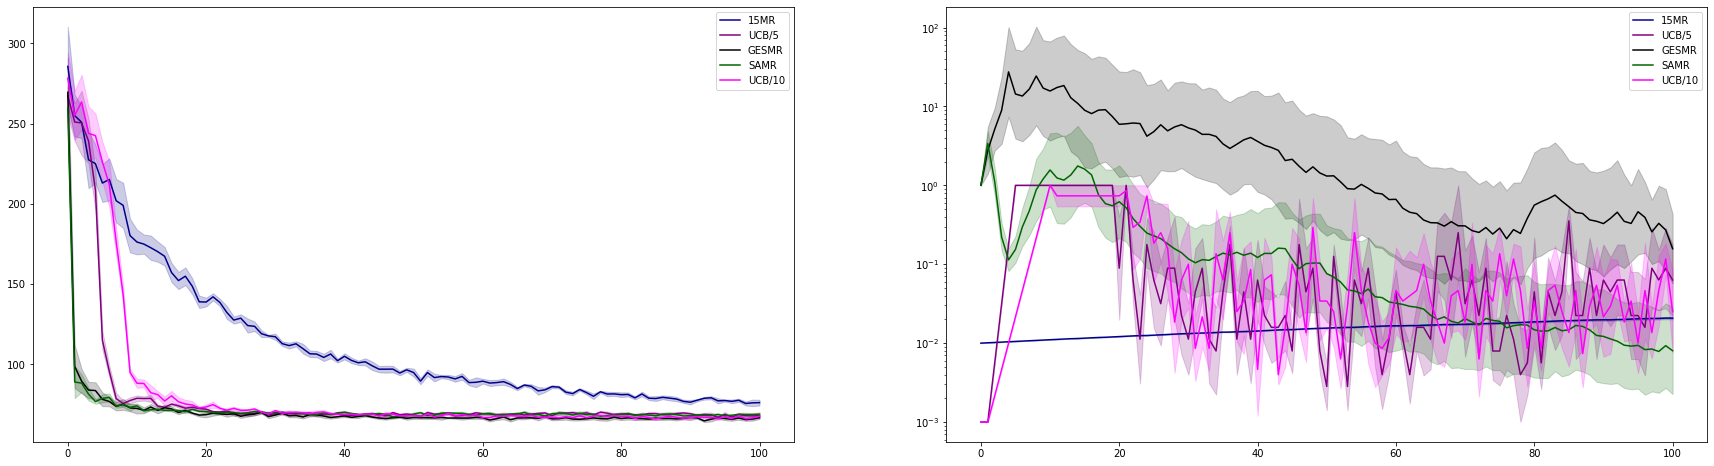

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(30,8))
for algo in algos_render:
    plt.sca(axs[0])
    viz.plot_mean_std(data[algo]['fits'], c=algo2color[algo], name=algo2label[algo],
                      render_plots=False, use_std_error=True)
    plt.sca(axs[1])
    viz.plot_mean_std(data[algo]['mrs'], c=algo2color[algo], name=algo2label[algo], logscale=True,
                      render_plots=False, use_std_error=True)
plt.legend()

In [26]:

data = {}
for task in ['mnist', 'fmnist', 'cartpole', 'pendulum', 'acrobot', 'mountain']:
    data[task] = {}
#     algos_render = subtract_list(algos_normal, ['1cmr'])
    algos_render = ['15mr', 'ucb_5', 'ucb_10', 'gsmr', 'nsmr', 'fmr']
    for algo in tqdm(algos_render):
        data[task][algo] = {'fits': [], 'mrs': []}
        for seed in range(5):
            config = torch.load(f'/work/08258/akumar01/maverick2/evolved-neuroevolution/data/{task}/config_{algo}_{seed}.pt')
            d = torch.load(f'/work/08258/akumar01/maverick2/evolved-neuroevolution/data/{task}/data_{algo}_{seed}.pt')
            data[task][algo]['fits'].append(d['fits'])
            data[task][algo]['mrs'].append(d['mrs'])
        data[task][algo]['fits'] = torch.stack(data[task][algo]['fits'])
        data[task][algo]['mrs'] = torch.stack(data[task][algo]['mrs'])


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [37]:
task2label = {
    'mnist': 'MNIST',
    'fmnist': 'Fashion-MNIST',
    'cartpole': 'CartPole',
    'pendulum': 'Pendulum',
    'acrobot': 'Acrobot',
    'mountain': 'MountainCar',
}

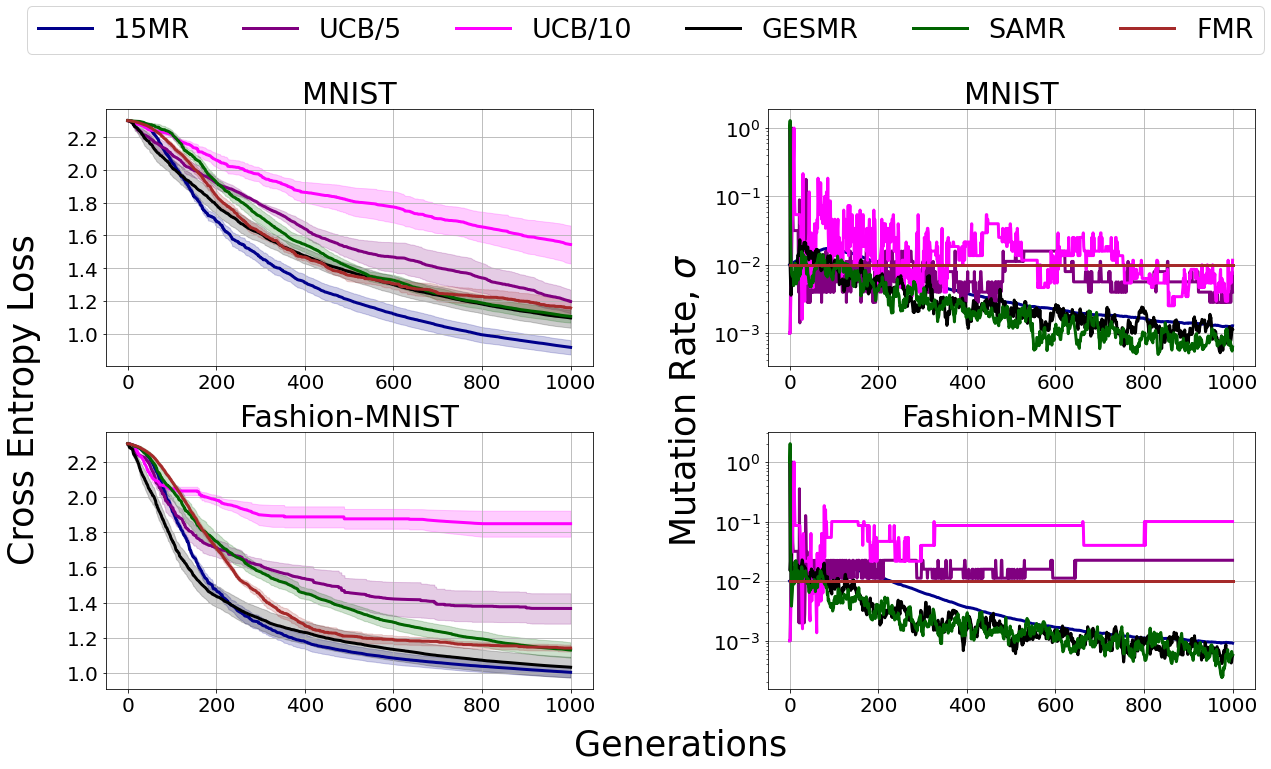

In [99]:
fig, axs = plt.subplots(2, 2, figsize=(20,12))
ax = fig.add_subplot(1, 2, 1); viz.empty_ax(ax)
plt.ylabel('Cross Entropy Loss', fontsize=35, labelpad=45)
ax = fig.add_subplot(1, 2, 2); viz.empty_ax(ax)
plt.ylabel('Mutation Rate, $\sigma$', fontsize=35, labelpad=45)
ax = fig.add_subplot(1, 1, 1); viz.empty_ax(ax)
plt.xlabel('Generations', fontsize=35, labelpad=25)

for taski, task in enumerate(['mnist', 'fmnist']):
    for algo in algos_render:
        plt.sca(axs[taski, 0])
        plt.grid(True)
        plt.title(f'{task2label[task]}', fontsize=30)
        viz.plot_mean_std(data[task][algo]['fits'], c=algo2color[algo], name=algo2label[algo],
                          render_plots=False, use_std_error=True, linewidth=3)
        plt.legend().remove()
        plt.xticks(fontsize=20); plt.yticks(fontsize=20)
        
        plt.sca(axs[taski, 1])
        plt.grid(True)
        plt.title(f'{task2label[task]}', fontsize=30)
        viz.plot_mean_std(data[task][algo]['mrs'], c=algo2color[algo], name=algo2label[algo], logscale=True,
                          render_std=False, render_plots=False, use_std_error=True, linewidth=3)
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend().remove()
        plt.xticks(fontsize=20); plt.yticks(fontsize=20)
    
ax.legend(handles, labels, fontsize=27, ncol=6, bbox_to_anchor=(1.02, 1.2))
plt.tight_layout()

plt.savefig('results/fits_mrs_mnist.png', dpi=300, bbox_inches='tight')
plt.show()


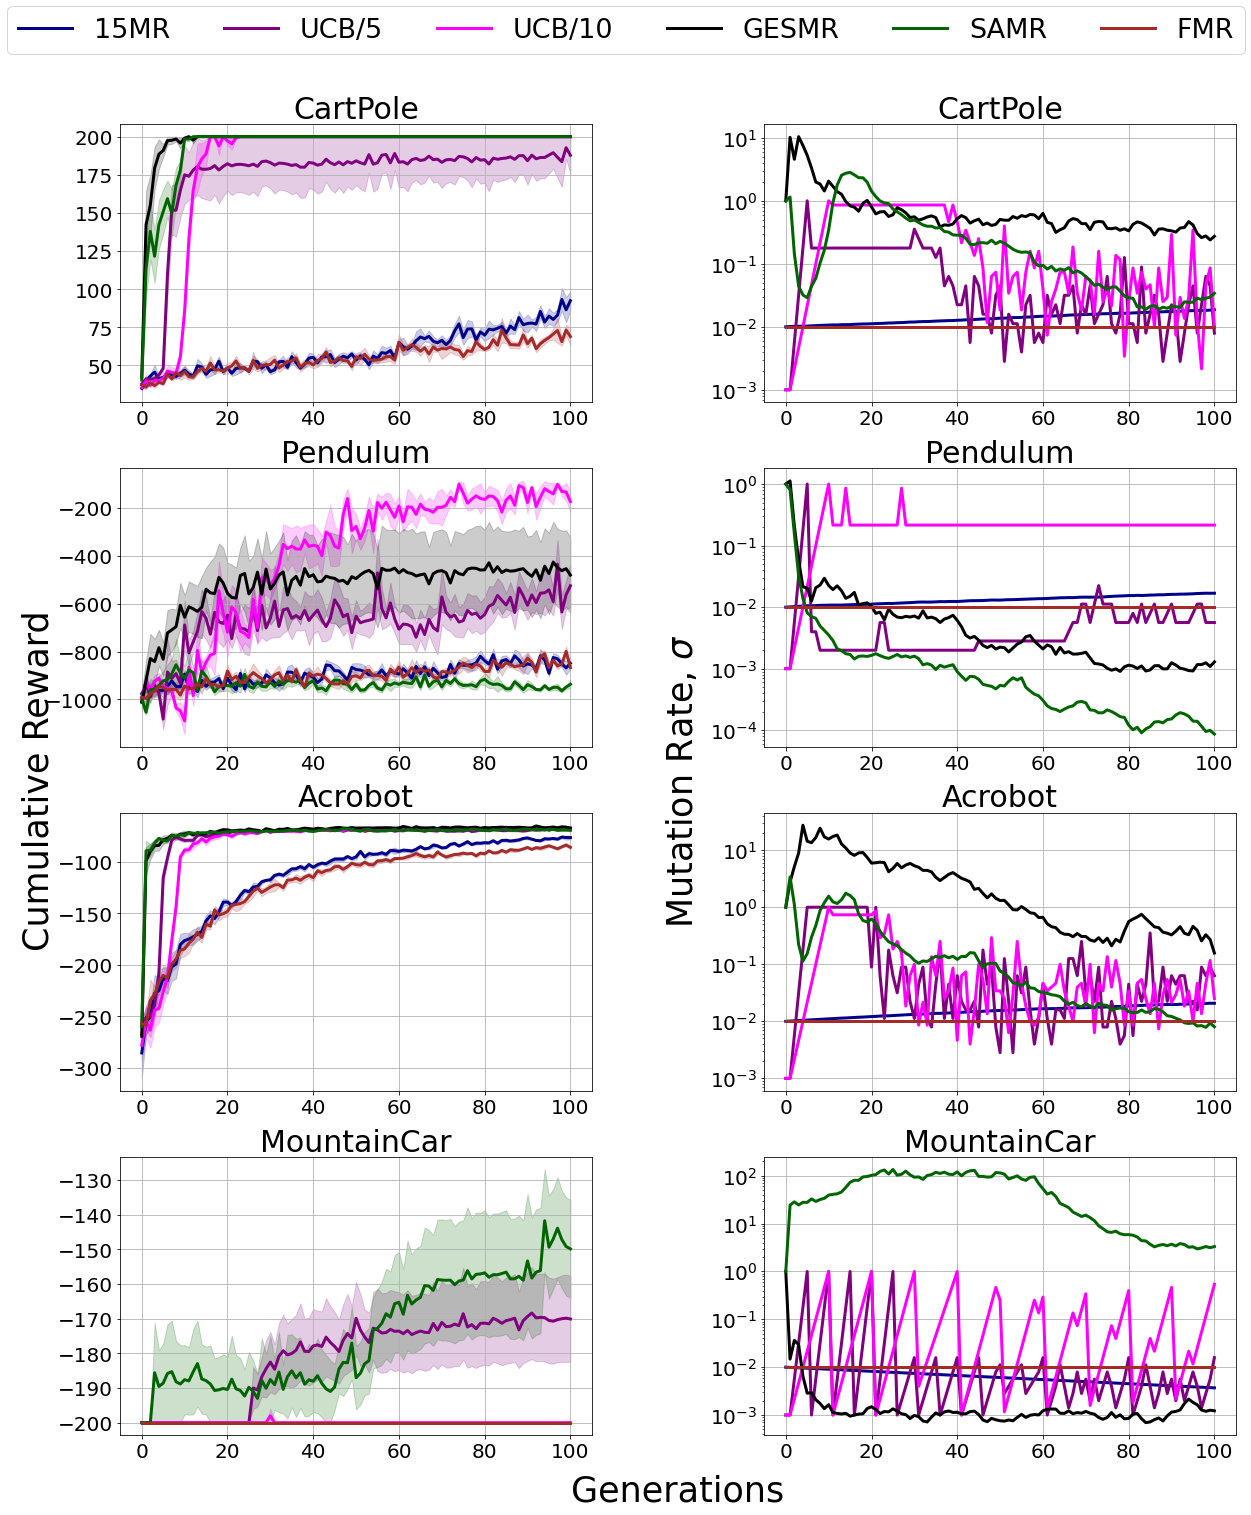

In [100]:
fig, axs = plt.subplots(4, 2, figsize=(20,22))
ax = fig.add_subplot(1, 2, 1); viz.empty_ax(ax)
plt.ylabel('Cumulative Reward', fontsize=35, labelpad=45)
ax = fig.add_subplot(1, 2, 2); viz.empty_ax(ax)
plt.ylabel('Mutation Rate, $\sigma$', fontsize=35, labelpad=45)
ax = fig.add_subplot(1, 1, 1); viz.empty_ax(ax)
plt.xlabel('Generations', fontsize=35, labelpad=25)

for taski, task in enumerate(['cartpole', 'pendulum', 'acrobot', 'mountain']):
    for algo in algos_render:
        plt.sca(axs[taski, 0])
        plt.grid(True)
        plt.title(f'{task2label[task]}', fontsize=30)
        viz.plot_mean_std(-data[task][algo]['fits'], c=algo2color[algo], name=algo2label[algo],
                          render_plots=False, use_std_error=True, linewidth=3)
        plt.legend().remove()
        plt.xticks(fontsize=20); plt.yticks(fontsize=20)
        
        plt.sca(axs[taski, 1])
        plt.grid(True)
        plt.title(f'{task2label[task]}', fontsize=30)
        viz.plot_mean_std(data[task][algo]['mrs'], c=algo2color[algo], name=algo2label[algo], logscale=True,
                          render_std=False, render_plots=False, use_std_error=True, linewidth=3)
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend().remove()
        plt.xticks(fontsize=20); plt.yticks(fontsize=20)
    
ax.legend(handles, labels, fontsize=27, ncol=6, bbox_to_anchor=(1.02, 1.1))
plt.tight_layout()

plt.savefig('results/fits_mrs_rl.png', dpi=300, bbox_inches='tight')
plt.show()


In [98]:
def create_experiment1_config():
    optim_fns = [ackley, rastrigin, rosenbrock, sphere, lin_fn]
    n_dims = [2, 30, 100, 1000]
    # init_pop_vars = [.1, 1, 5, 10]
    init_pop_vars = [1, 10]
    n_seed = 1
    n_gen = 500
    n_pop = 101

    config = []

    for optim_fn in optim_fns:
        for n_dim in n_dims:
            for init_pop_var in init_pop_vars:
#                 for algo in algos_normal:
                for algo in ['gsmr']:
                    ng = n_gen
                    if optim_fn==lin_fn:
                        ng = 100
                    elif optim_fn==ackley and n_dim==1000:
                        ng = 4000
                    config_i = {
                        'optim_fn': optim_fn,
                        'n_dim': n_dim,
                        'init_pop_var': init_pop_var,
                        'n_gen': ng,
                        'n_pop': n_pop,
                        'algo': algo,
                        'n_seed': n_seed,
                    }
                    config.append(config_i)

    data = []
    
    for ci in config:
        di = np.zeros((ci['n_seed'], ci['n_gen']+1, 2))
        di = xr.DataArray(di, dims=('seed', 'gen', 'fits_mrs'),
                            coords={'seed': list(range(ci['n_seed'])),
                                    'gen': list(range(ci['n_gen']+1)),
                                    'fits_mrs': ['fits', 'mrs']})
        data.append(di)
    return config, data
config, data = create_experiment1_config()

In [99]:
for ci, di in zip(tqdm(config), data):
    for seed in range(ci['n_seed']):
        do_seed(0)
        pop = torch.randn(ci['n_pop'], ci['n_dim'])*ci['init_pop_var']
        res = algo2algo_fn[ci['algo']](pop, ci['optim_fn'], ci['n_gen'])
        pops, fits, mrs = res[:3]
        fits = fits.min(dim=-1).values
        while mrs.ndim>1:
            mrs = mrs.log().mean(dim=-1).exp()
        
        a = di.sel(seed=seed, fits_mrs='fits')
        a[:] = fits.detach().cpu().numpy()
        a = di.sel(seed=seed, fits_mrs='mrs')
        a[:] = mrs.detach().cpu().numpy()


  0%|          | 0/40 [00:00<?, ?it/s]

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 1000, 'init_pop_var': 10, 'n_gen': 10000, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


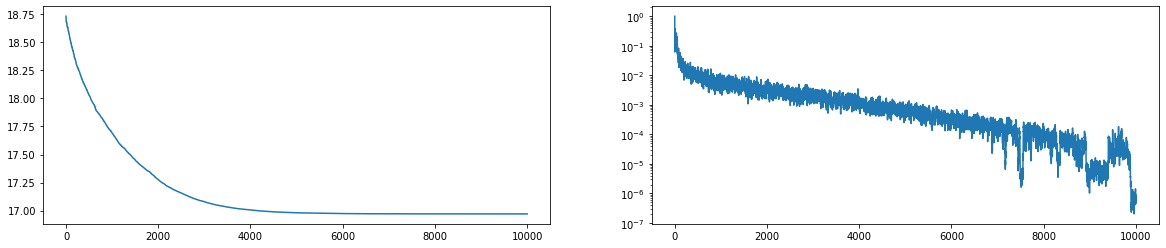

In [109]:
print(config[7])
plt.figure(figsize=(20,4))
plt.subplot(121);plt.plot(data[7][0, :, 0])
plt.subplot(122);plt.plot(data[7][0, :, 1])
plt.yscale('log')

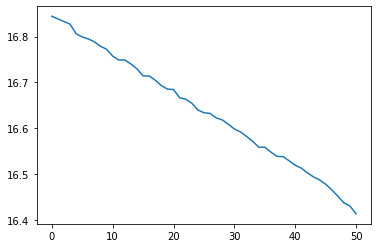

In [122]:
pop = torch.randn(101, 40)*10.
pops, fits = optim.run_evolution_base(pop, ackley, 50, mr=1e-2)
plt.plot(fits.min(dim=-1).values);

In [123]:
fits.shape

torch.Size([51, 101])

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 2, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


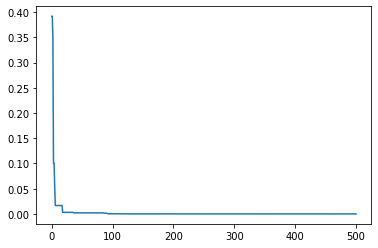

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 2, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


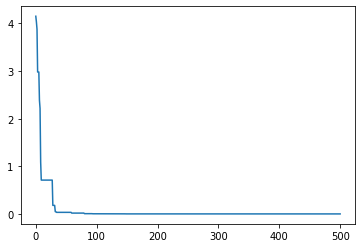

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 30, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


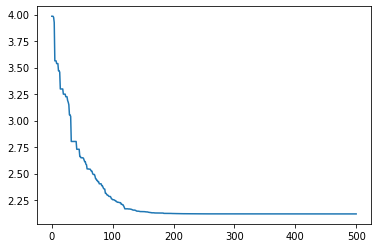

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 30, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


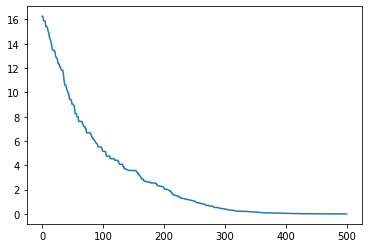

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 100, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


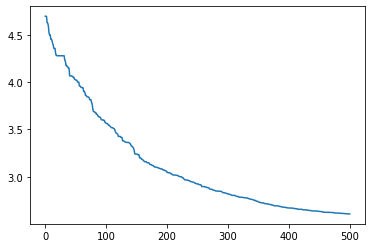

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 100, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


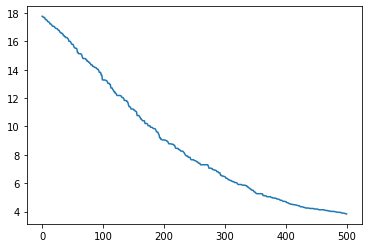

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 1000, 'init_pop_var': 1, 'n_gen': 10000, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


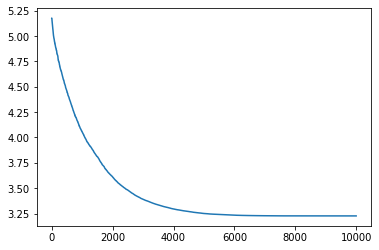

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 1000, 'init_pop_var': 10, 'n_gen': 10000, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


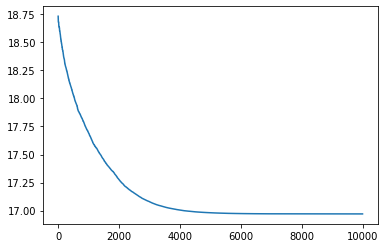

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 2, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


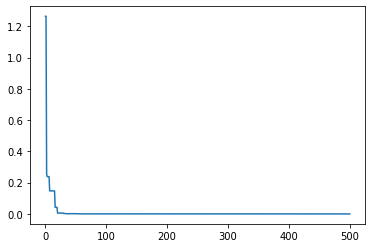

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 2, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


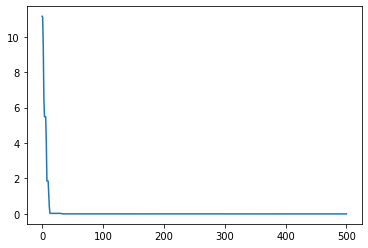

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 30, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


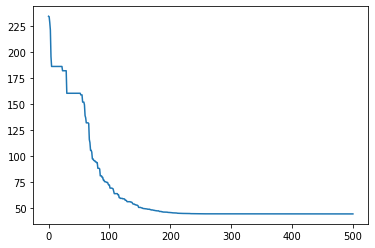

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 30, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


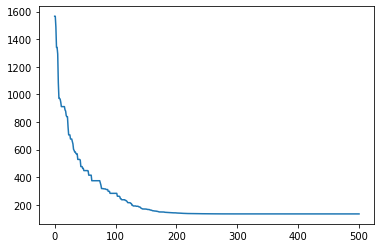

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 100, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


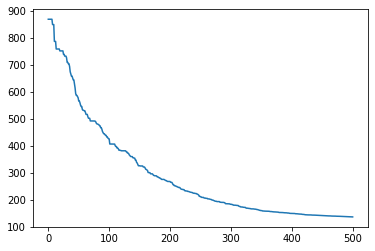

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 100, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


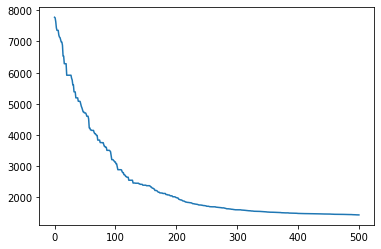

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 1000, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


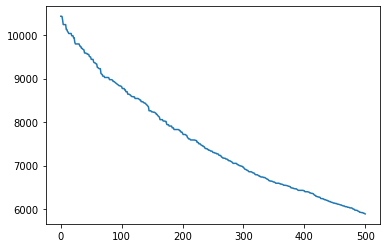

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 1000, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


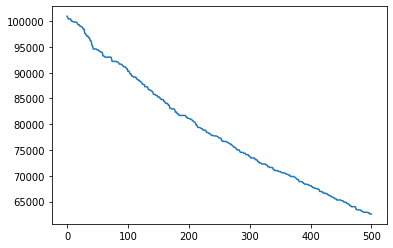

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 2, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


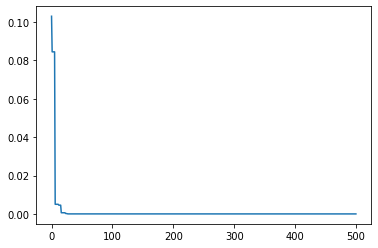

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 2, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


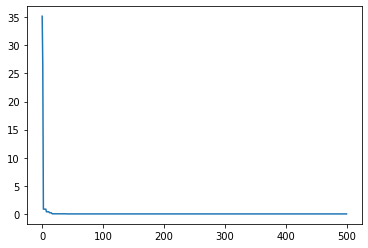

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 30, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


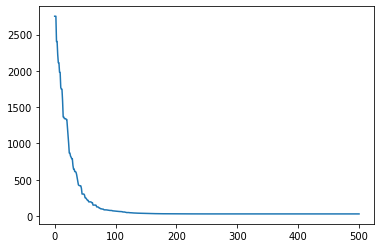

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 30, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


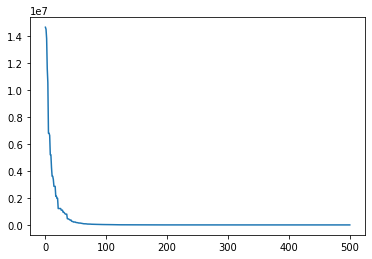

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 100, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


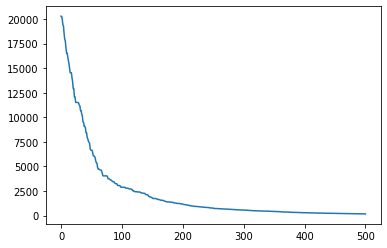

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 100, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


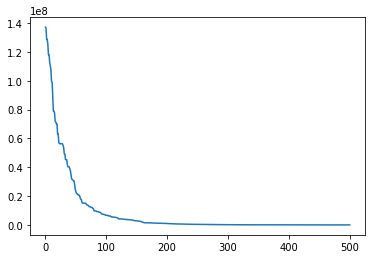

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 1000, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


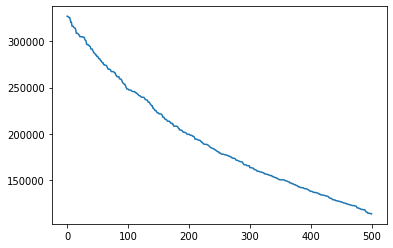

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 1000, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


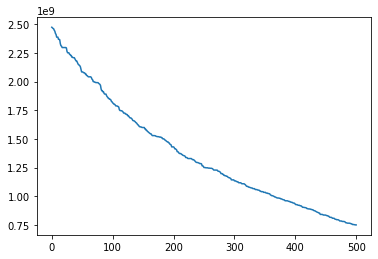

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 2, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


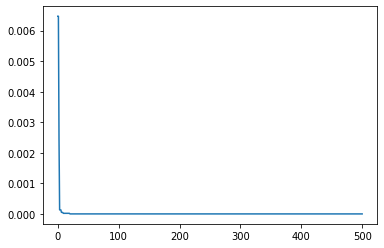

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 2, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


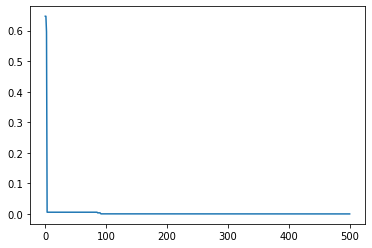

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 30, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


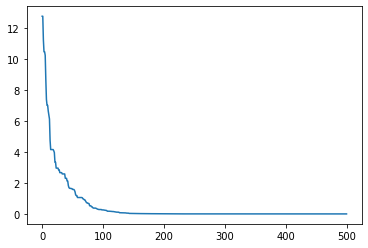

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 30, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


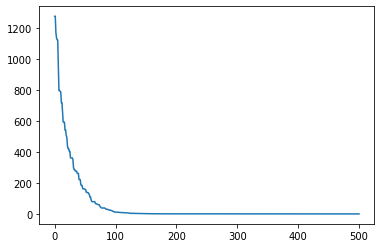

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 100, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


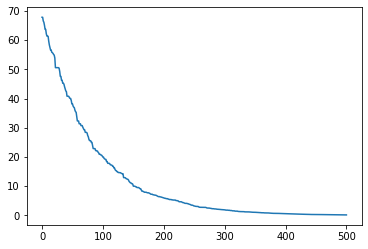

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 100, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


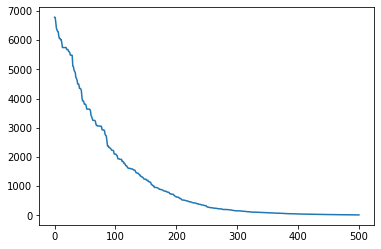

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 1000, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


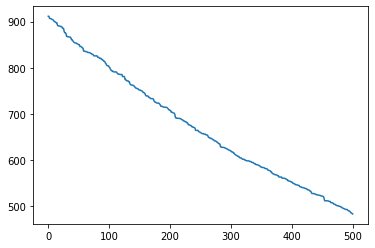

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 1000, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


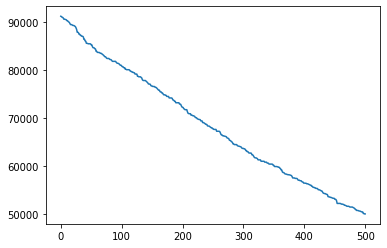

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 2, 'init_pop_var': 1, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


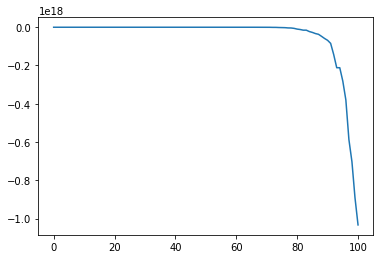

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 2, 'init_pop_var': 10, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


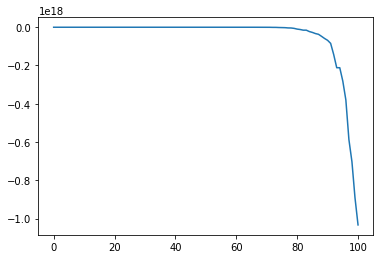

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 30, 'init_pop_var': 1, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


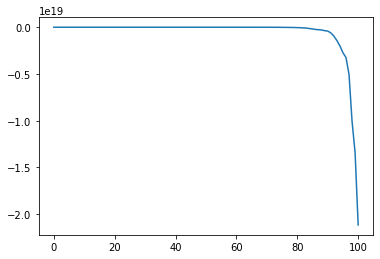

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 30, 'init_pop_var': 10, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


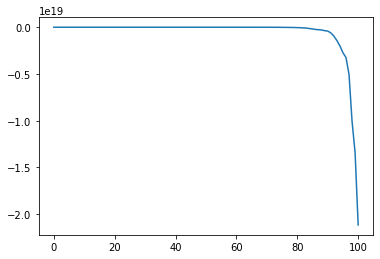

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 100, 'init_pop_var': 1, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


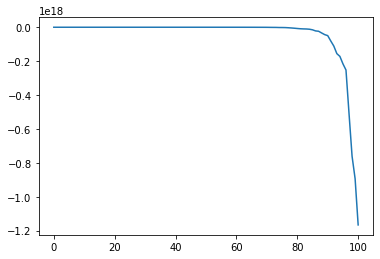

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 100, 'init_pop_var': 10, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


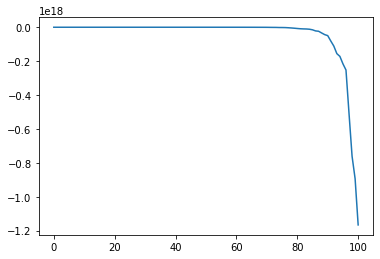

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 1000, 'init_pop_var': 1, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


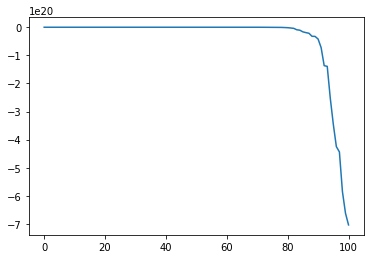

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 1000, 'init_pop_var': 10, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


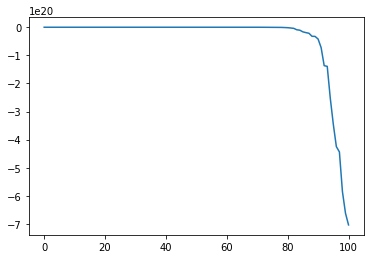

In [100]:
for ci, di in zip(config, data):
    print(ci)
    plt.plot(di[0, :, 0])
    plt.show()
    